In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from admm import ADMMQuantizer
# papers with code formulas: https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_6.00.39_PM.png

In [2]:
def train_epoch(model, dataloader, optimizer, criterion, admm_quantizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        base_loss = criterion(outputs, labels)
        
        # Apply ADMM penalty to the loss
        if admm_quantizer is not None:
            augmented_loss = admm_quantizer.apply_loss_penalty(base_loss)
        else:
            augmented_loss = base_loss
        
        augmented_loss.backward()

        # Manual gradient injection for ADMM proximal update
        if admm_quantizer is not None:
            for name, param in model.named_parameters():
                if name in admm_quantizer.quantize_layers and param.grad is not None:
                    g = admm_quantizer.G[name]
                    lmbda = admm_quantizer.lmbda[name]
                    update_term = admm_quantizer.rho * (param.data - g + lmbda).view_as(param)
                    param.grad.data.add_(update_term)

        optimizer.step()

        running_loss += augmented_loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [3]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [8]:
def apply_final_quantization(model, admm_quantizer):
    """
    Replaces the full-precision weights in the model with their quantized G counterparts
    for inference.
    """
    print("Applying final quantization to model weights...")
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in admm_quantizer.quantize_layers:
                # Copy the quantized G values into the model's parameters
                param.copy_(admm_quantizer.G[name].view_as(param))
    print("Model weights permanently quantized.")

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Convert 1-channel MNIST to RGB
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST normalization (standard values)
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 2. Model Initialization (ResNet-18)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 classes for MNIST
model = model.to(device)

# 3. ADMM Configuration
# Identify layers to quantize: typically Conv2d and Linear layers' weights
quantize_layers = []
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if hasattr(module, 'weight'):
            quantize_layers.append(f"{name}.weight")

print(f"Layers selected for ADMM quantization: {quantize_layers}")

initial_lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# --- Phase 1: Warmup training (no ADMM) ---
print("Warmup: Training model in float32 before quantization...")
for epoch in range(2):
    train_epoch(model, train_loader, optimizer, criterion, admm_quantizer=None, device=device)

admm_rho = 1e-3 # penalty parameter for ADMM
admm_target_bits = 2 # For ternary quantization
admm_quantizer = ADMMQuantizer(model, quantize_layers, rho=admm_rho, target_bits=admm_target_bits)

num_admm_iterations = 3 # Number of ADMM outer iterations (where G, lambda are updated)
epochs_per_admm_iter = 1 # Number of gradient descent epochs for W-update per ADMM iter
full_precision_bits = 32 # For float32

# Lists to store results for plotting
admm_iter_labels = ["Initial (FP32)"] + [f"ADMM Iter {i+1}" for i in range(num_admm_iterations)] + ["Final Quantized"]
accuracy_history = []
effective_bits_history = []

# Initial evaluation (Full Precision)
print("\n--- Initial Evaluation (Full Precision) ---")
loss, acc = evaluate_model(model, test_loader, criterion, device)
print(f"Initial Test Loss: {loss:.4f}, Initial Test Acc: {acc:.4f}")
accuracy_history.append(acc)
effective_bits_history.append(full_precision_bits) # Model is initially full precision

# ADMM Training Loop
for admm_iter_idx in range(num_admm_iterations):
    print(f"\n--- ADMM Outer Iteration {admm_iter_idx + 1}/{num_admm_iterations} ---")

    # Step 1: W-update (Train with augmented loss)
    print(f"--- Fine-tuning for {epochs_per_admm_iter} epochs with ADMM penalty ---")
    for epoch in range(epochs_per_admm_iter):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, admm_quantizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        print(f"ADMM Iter {admm_iter_idx+1}, Epoch {epoch+1}/{epochs_per_admm_iter} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Step 2 & 3: G-update and lambda-update
    admm_quantizer.step()
    print(f"G and lambda updated after ADMM Outer Iteration {admm_iter_idx + 1}")

    # Evaluate model after W, G, lambda updates (still conceptually full-precision W)
    _, current_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Accuracy after ADMM Outer Iter {admm_iter_idx+1} (W still FP32): {current_acc:.4f}")
    accuracy_history.append(current_acc)
    # During ADMM training, the model weights are still full-precision,
    # so effective bit-width remains 32 bits for the `param.data`.
    effective_bits_history.append(full_precision_bits)


print("\n--- ADMM Training Completed ---")

# Final Evaluation of the fully quantized model
# Apply the final quantization by copying G to model weights
apply_final_quantization(model, admm_quantizer)

# Evaluate the truly quantized model
final_quantized_loss, final_quantized_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Final Quantized Model Test Loss: {final_quantized_loss:.4f}, Final Quantized Model Test Acc: {final_quantized_acc:.4f}")
print(f"Effective bit width: {admm_quantizer.calculate_effective_bit_width_admm(full_precision_bits)}")
# Append the final quantized model's accuracy and its target bit-width
accuracy_history.append(final_quantized_acc)
effective_bits_history.append(admm_quantizer.target_bits)

Using device: mps
Layers selected for ADMM quantization: ['conv1.weight', 'layer1.0.conv1.weight', 'layer1.0.conv2.weight', 'layer1.1.conv1.weight', 'layer1.1.conv2.weight', 'layer2.0.conv1.weight', 'layer2.0.conv2.weight', 'layer2.0.downsample.0.weight', 'layer2.1.conv1.weight', 'layer2.1.conv2.weight', 'layer3.0.conv1.weight', 'layer3.0.conv2.weight', 'layer3.0.downsample.0.weight', 'layer3.1.conv1.weight', 'layer3.1.conv2.weight', 'layer4.0.conv1.weight', 'layer4.0.conv2.weight', 'layer4.0.downsample.0.weight', 'layer4.1.conv1.weight', 'layer4.1.conv2.weight', 'fc.weight']
Warmup: Training model in float32 before quantization...


Training: 100%|██████████| 938/938 [03:54<00:00,  4.00it/s]



--- Initial Evaluation (Full Precision) ---


Evaluating: 100%|██████████| 79/79 [00:16<00:00,  4.69it/s]


Initial Test Loss: 0.0172, Initial Test Acc: 0.9950

--- ADMM Outer Iteration 1/3 ---
--- Fine-tuning for 1 epochs with ADMM penalty ---


Evaluating: 100%|██████████| 79/79 [00:11<00:00,  7.18it/s]


ADMM Iter 1, Epoch 1/1 - Train Loss: 0.2777, Train Acc: 0.9970 | Test Loss: 0.0237, Test Acc: 0.9927
G and lambda updated after ADMM Outer Iteration 1


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Test Accuracy after ADMM Outer Iter 1 (W still FP32): 0.9927

--- ADMM Outer Iteration 2/3 ---
--- Fine-tuning for 1 epochs with ADMM penalty ---


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.27it/s]


ADMM Iter 2, Epoch 1/1 - Train Loss: 0.7366, Train Acc: 0.9978 | Test Loss: 0.0127, Test Acc: 0.9956
G and lambda updated after ADMM Outer Iteration 2


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


Test Accuracy after ADMM Outer Iter 2 (W still FP32): 0.9956

--- ADMM Outer Iteration 3/3 ---
--- Fine-tuning for 1 epochs with ADMM penalty ---


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


ADMM Iter 3, Epoch 1/1 - Train Loss: 1.2596, Train Acc: 0.9984 | Test Loss: 0.0161, Test Acc: 0.9944
G and lambda updated after ADMM Outer Iteration 3


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]


Test Accuracy after ADMM Outer Iter 3 (W still FP32): 0.9944

--- ADMM Training Completed ---
Applying final quantization to model weights...
Model weights permanently quantized.


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]

Final Quantized Model Test Loss: 0.3459, Final Quantized Model Test Acc: 0.8873
Effective bit width: 2.0257833330739796



--- Plotting Results ---
Debug: len(admm_iter_labels)=5
Debug: len(accuracy_history)=5
Debug: len(effective_bits_history)=5


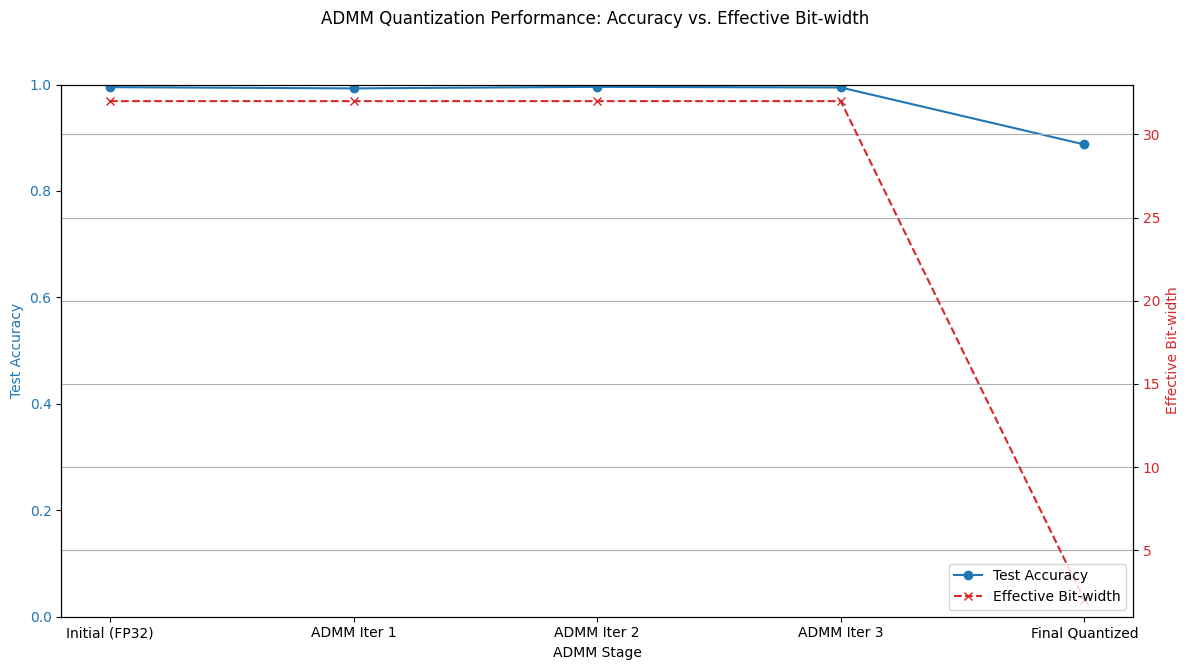

In [10]:
# --- Plotting the results ---
print("\n--- Plotting Results ---")

# Ensure labels match data points
print(f"Debug: len(admm_iter_labels)={len(admm_iter_labels)}")
print(f"Debug: len(accuracy_history)={len(accuracy_history)}")
print(f"Debug: len(effective_bits_history)={len(effective_bits_history)}")

# The labels should match 1 (initial) + num_admm_iterations (intermediate) + 1 (final quantized)
expected_len = 1 + num_admm_iterations + 1
assert len(admm_iter_labels) == expected_len and \
        len(accuracy_history) == expected_len and \
        len(effective_bits_history) == expected_len, \
        f"Mismatch in lengths: labels={len(admm_iter_labels)}, acc={len(accuracy_history)}, bits={len(effective_bits_history)}. Expected: {expected_len}"

fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('ADMM Stage')
ax1.set_ylabel('Test Accuracy', color=color)
ax1.plot(admm_iter_labels, accuracy_history, marker='o', linestyle='-', color=color, label='Test Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.0, 1.0) # Accuracy range

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Effective Bit-width', color=color)
ax2.plot(admm_iter_labels, effective_bits_history, marker='x', linestyle='--', color=color, label='Effective Bit-width')
ax2.tick_params(axis='y', labelcolor=color)
# Set y-axis limits for bit-width. Max is 32, min is `target_bits`
ax2.set_ylim(admm_target_bits - 1, full_precision_bits + 1) 

fig.suptitle('ADMM Quantization Performance: Accuracy vs. Effective Bit-width')
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

plt.grid(True)
plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for better readability
plt.show()